# Homework 04 - kMeans

自己编写kMeans方法，并使用下面的数据来做聚类

![data](data/data.png)

数据文件是：`dataset_circles.csv`，其中

* 数据的第一列是`x`坐标，
* 第二列是`y`坐标，
* 第三列是样本点的类别。



**要求：**

1. 使用**自己编写的聚类方法**对数据进行聚类
2. 将数据可视化出来，自己分析数据的特点，找到一种方法将数据进行某种变换，在变换后的空间上使用自己编写的kMeans方法对数据进行聚类处理
3. 自己查找其他的聚类方法，尝试使用一下，看看效果如何。（最好能自己编写）


## 自定义kMeans算法

### 1. 方法

由于具有出色的速度和良好的可扩展性，K-Means聚类算法最经典的聚类方法。***k-Means算法是一个重复移动类中心点（重心，centroids）的过程***:
* 移动中心点到其包含成员的平均位置;
* 然后重新划分其内部成员。

`k`是算法中的超参数，表示类的数量；k-Means可以自动分配样本到不同的类，但是不能决定究竟要分几个类。`k`必须是一个比训练集样本数小的正整数。有时，类的数量是由问题内容指定的。例如，一个鞋厂有三种新款式，它想知道每种新款式都有哪些潜在客户，于是它调研客户，然后从数据里找出三类。也有一些问题没有指定聚类的数量，最优的聚类数量是不确定的。

k-Means的参数是类的重心位置和其内部观测值的位置。与广义线性模型和决策树类似，k-Means参数的最优解也是以代价函数(cost function)最小化为目标。k-Means代价函数公式如下：
$$
J = \sum_{k=1}^{K} \sum_{i \in C_k} | x_i - u_k|^2
$$

($C_k$表示第k类的样本集合, $u_k$是第$k$个类的重心位置(centriod poisition))

$u_k$是第$k$个类的重心位置，定义为：
$$
u_k = \frac{1}{|C_k|} \sum_{i \in C_k} x_i
$$


成本函数是各个类畸变程度（distortions）之和。每个类的畸变程度等于该类重心与其内部成员位置距离的平方和。若类内部的成员彼此间越紧凑则类的畸变程度越小，反之，若类内部的成员彼此间越分散则类的畸变程度越大。

### 2.算法步骤：

求解成本函数最小化的参数就是一个重复配置每个类包含的观测值，并不断移动类重心的过程。

输入：$T=\{ x_1, x_2, ..., x_N\}$，其中$x_i \in R_n$，i=1,2...N

输出：聚类集合$C_k$, 聚类中心$u_k$, 其中k=1,2,...K

1. 初始化类的重心$u_k$，可以随机选择样本作为聚类中心
2. 每次迭代的时候，把所有样本分配到离它们最近的类，即更新聚类集合$C_k$
3. 然后把重心移动到该类全部成员位置的平均值那里，即更新$u_k$
4. 若达到最大迭代步数，或两次迭代差小于设定的阈值则算法结束，否则重复步骤2

Reference: https://www.biaodianfu.com/k-means.html

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

### Sample data

In [4]:
data1 = pd.read_csv("data/dataset_circles.csv", dtype={0:float, 1:float, 2:int}).values
cluster1_data = data1[data1[:, 2] == 0]
cluster2_data = data1[data1[:, 2] == 1]

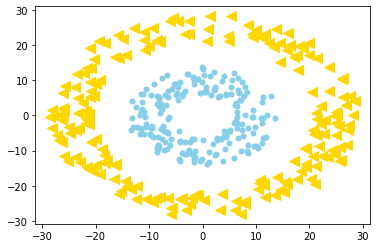

In [5]:
plt.figure(figsize=(6, 4))
plt.scatter(cluster1_data[:, 0], cluster1_data[:, 1], marker=".", color="skyblue", s=100)
plt.scatter(cluster2_data[:, 0], cluster2_data[:, 1], marker="<", color="gold", s=100)
plt.show()

In [11]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=500, n_features=2, cluster_std=1.0, centers=[(7, 0), (0, 0), (5, 5)],
                      shuffle=True, random_state=42)
data2 = np.concatenate([X, y.reshape(len(y), 1)], axis=1)
cluster1_data = data2[data2[:, 2] == 0]
cluster2_data = data2[data2[:, 2] == 1]
cluster3_data = data2[data2[:, 2] == 2]

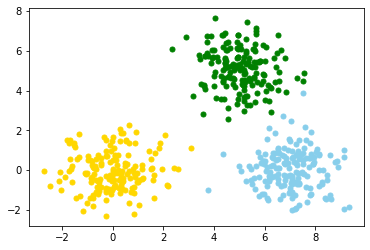

In [13]:
plt.figure(figsize=(6, 4))
plt.scatter(cluster1_data[:, 0], cluster1_data[:, 1], marker=".", color="skyblue", s=100)
plt.scatter(cluster2_data[:, 0], cluster2_data[:, 1],  marker=".", color="gold", s=100)
plt.scatter(cluster3_data[:, 0], cluster3_data[:, 1],  marker=".", color="green", s=100)
plt.show()

### kMeans class

In [14]:
class KMeans():

    def __init__(self, data, k=2, max_iter=100, cost_threshold=100):
        self.data = np.asarray(data)
        self.k = k
        self.max_iter = max_iter
        self.cost_value = 0
        self.cost_threshold = cost_threshold
        self.labels = np.zeros(shape=(len(self.data),))

    def _square_distance(self, x, centriod):
        # Calculate Euclidean distance
        # np.sqrt(np.square(vecA - vecB).sum())
        # np.linalg.norm(vecA - vecB)
        return cdist(XA=x, XB=centriod, metric = 'euclidean')

    def _init_centriod(self):
        choice_index = np.random.choice(a=len(self.data), size=self.k, replace=False)
        self.centriods = self.data[choice_index, :]

    def _update_centriod(self, x):
        return np.mean(np.asarray(x), axis=0)

    def _cluster(self):

        self._init_centriod()

        for i in range(self.max_iter):
            centriods = self.centriods
            dist_data = None

            for j in range(self.k):
                centriod = centriods[j, :].reshape(1, 2)
                k_dist_data = self._square_distance(x=self.data, centriod=centriod)
                dist_data = k_dist_data if dist_data is None else np.concatenate([dist_data, k_dist_data], axis=1)
            k_labels = np.argmin(dist_data, axis=1)

            cost_value = 0
            clusters = {}
            for j in range(self.k):
                centriod = centriods[j, :].reshape(1, 2)
                k_data = self.data[k_labels == j]
                clusters[j] = k_data

                k_dist_data = self._square_distance(x=k_data, centriod=centriod)
                cost_value += np.sum(k_dist_data, axis=0)[0]
                centriods[j, :] = self._update_centriod(x=k_data)

            labels_diff = self.labels == k_labels
            self.cost_value = cost_value
            self.centriods = centriods
            self.labels = k_labels
            self.iter_count = i
            self.clusters = clusters

            if False not in labels_diff and cost_value < self.cost_threshold:
                break

    def result(self):
        self._cluster()

In [16]:
# KMeans clustering
kmc1 = KMeans(data=data1[:, :2], k=2, max_iter=1000)
kmc1.result()
print('iterated', kmc1.iter_count, 'times')
print('cost value', kmc1.cost_value)

iterated 999 times
cost value 5454.03213879672


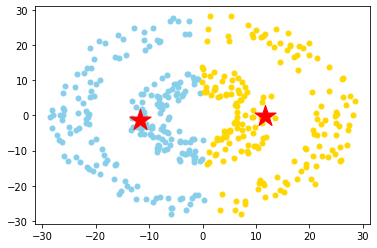

In [17]:
colors = ["skyblue", "gold"]
plt.figure(figsize=(6, 4))
for (i, k_data), color in zip(kmc1.clusters.items(), colors):
    centriod = kmc1.centriods[i, :]
    plt.scatter(k_data[:, 0], k_data[:, 1], marker=".", color=color, s=100, label=str(i))
    plt.scatter(centriod[0], centriod[1], marker="*", color="red", s=500)
plt.show()

In [20]:
kmc2 = KMeans(data=data2[:, :2], k=3, max_iter=10000, cost_threshold=700)
kmc2.result()
print('iterated', kmc2.iter_count, 'times')
print('cost value', kmc2.cost_value)

iterated 4 times
cost value 611.3879396454864


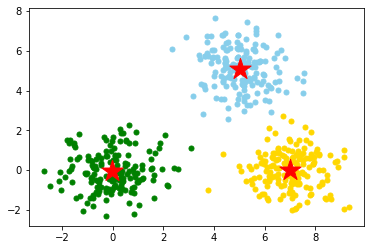

In [21]:
colors = ["skyblue", "gold", "green"]
plt.figure(figsize=(6, 4))
for (i, k_data), color in zip(kmc2.clusters.items(), colors):
    centriod = kmc2.centriods[i, :]
    plt.scatter(k_data[:, 0], k_data[:, 1], marker=".", color=color, s=100, label=str(i))
    plt.scatter(centriod[0], centriod[1], marker="*", color="red", s=500)
plt.show()

### bisecting KMeans

为克服K-Means算法收敛于局部最小的问题，有人提出了另一种称为二分K-Means(bisecting K-Means)的算法。该算法首先将所有点作为一个簇，然后将该簇一分为二。之后选择其中一个簇继续进行划分，选择哪一个簇进行划分取决于对其划分时候可以最大程度降低 SSE（平方和误差）的值。上述基于 SSE 的划分过程不断重复，直到得到用户指定的簇数目为止。

二分 K-Means 聚类算法伪代码：

将所有点看成一个簇
当簇数目小于 k 时，对于每一个簇
计算总误差
在给定的簇上面进行 KMeans 聚类（k=2）
计算将该簇一分为二之后的总误差
选择使得误差最小的那个簇进行划分操作